# Autoregressive Tree HMM Demo

### TODO 
- Fix initialize -- use active mask
- Bernouli likelihood
- Optional division transition matrix - ie just reuse 

## Setup

In [30]:
import sys
import os
import importlib
# sys.path.insert(0, os.path.expanduser('~/Documents/dynamax'))


In [31]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import seaborn as sns

from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from models.tarhmm import tARHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation
from dynamax.hidden_markov_model.models.tarhmm import tree_hmm_backward_filter
from typing import Callable, Optional
from dynamax.types import IntScalar, Float, Array


### Helper functions for plotting

In [32]:
sns.set_style("white")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

## Sample from tree ARHMM
GPT-written function to sample from this model. To be replaced by better sampler later.

In [33]:
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
from jax.scipy.stats import multivariate_normal
from utils import generate_tree_hmm_data
key = jr.PRNGKey(1)
data = generate_tree_hmm_data(key)

Generated sparse data for 60 steps.
Total Unique Cells Created: 50


In [34]:
emissions = data['observations']
num_states = 3
emission_dim = 2
num_lags = 1

In [35]:
arhmm = tARHMM(num_states, emission_dim, num_lags=num_lags)
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)
inputs = arhmm.compute_inputs(emissions,                        
    data['parent_indices'],
    data['is_division_mask'],
    data['is_new_root_mask'],
    data['active_mask'])
# arhmm.e_step(params, emissions,inputs=inputs)


In [36]:
from dynamax.hidden_markov_model.models.tarhmm import tree_hmm_filter, tree_hmm_two_filter_smoother
# post = tree_hmm_filter(*arhmm._inference_args(params, emissions, inputs, data['parent_indices'], data['is_division_mask'], data['active_mask'],data['is_new_root_mask']))
# input_fwd = arhmm._inference_args(params, emissions, inputs, data['parent_indices'], data['is_division_mask'], data['active_mask'],data['is_new_root_mask'])
def inputs_for_backward_filter(
    initial_distribution,   # (num_states,)
    transition_matrices,    # tuple of (P_std, P_div) each (num_states, num_states)
    log_likelihoods,        # (T, MAX_CELLS, K)
    parent_indices,         # (T, MAX_CELLS)
    is_division_mask,       # (T, MAX_CELLS)
    active_mask,            # (T, MAX_CELLS)
    is_new_root_mask,       # (T, MAX_CELLS)
    transition_fn: Optional[Callable[[IntScalar], Float[Array, "num_states num_states"]]] = None,
    division_transition_fn: Optional[Callable[[IntScalar], Float[Array, "num_states num_states"]]] = None
):
    return transition_matrices, log_likelihoods, parent_indices, is_division_mask, active_mask, is_new_root_mask
# transition_matrices, log_likelihoods, parent_indices, is_division_mask, active_mask, is_new_root_mask = inputs_for_backward_filter(*input_fwd)
# log_normalizer, backward_pred_probs = tree_hmm_backward_filter(*inputs_for_backward_filter(*input_fwd))
# post = tree_hmm_two_filter_smoother(*input_fwd)

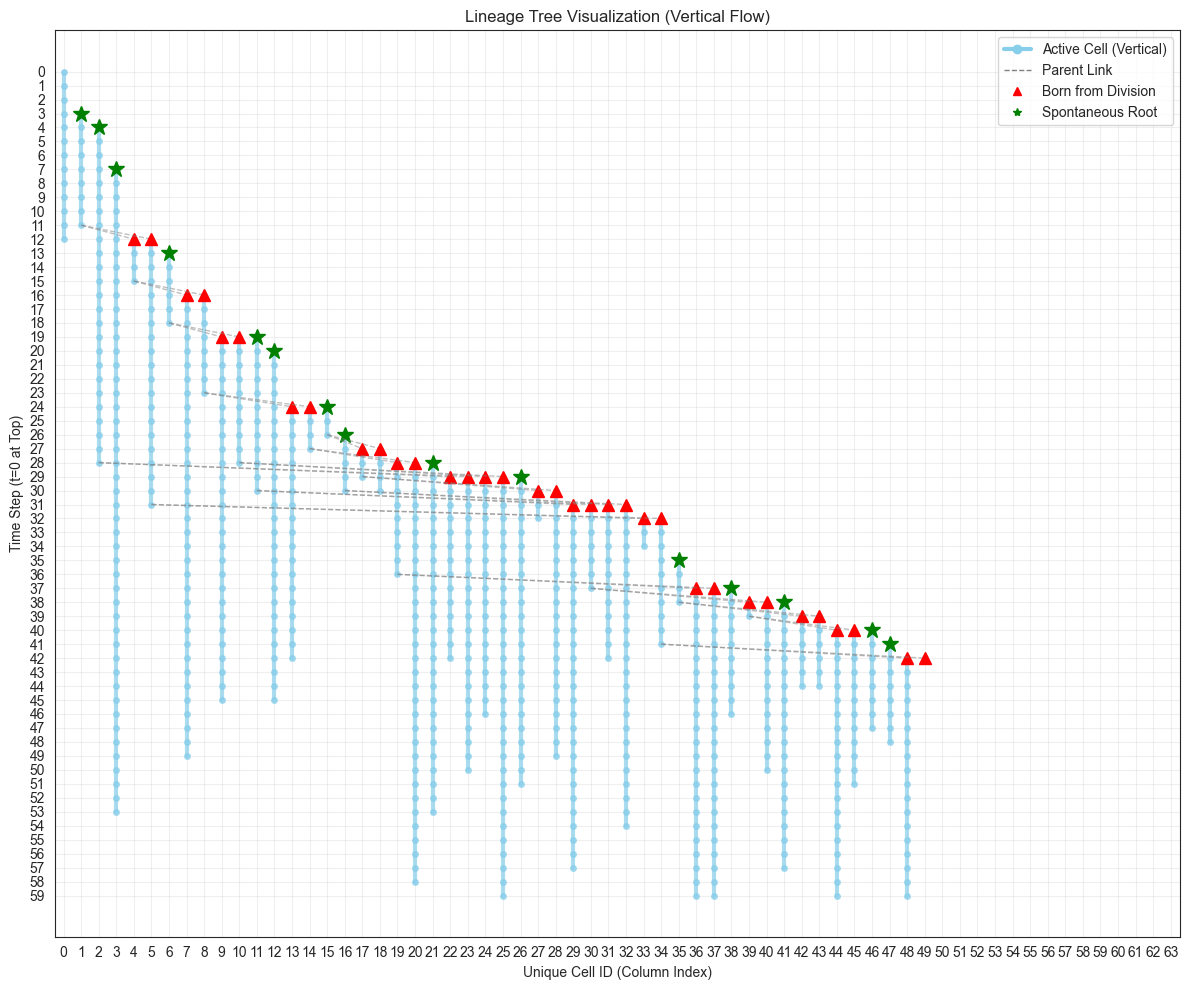

In [37]:
import matplotlib.pyplot as plt
import jax.random as jr
import jax.numpy as jnp
import numpy as np
from utils import visualize_lineage


    

visualize_lineage(data)

In [38]:
# cell_id = 3
# pd.DataFrame({'active':data['active_mask'][:,cell_id],'is_division':data['is_division_mask'][:,cell_id],'is_new_root':data['is_new_root_mask'][:,cell_id],'parent_id':data['parent_indices'][:,cell_id]})

In [39]:
emissions.shape

(60, 50, 2)

In [40]:
data['active_mask']

Array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False,  True, False]], dtype=bool)

In [41]:
arhmm = tARHMM(num_states, emission_dim, num_lags=num_lags)
# initialize over a single file? 
params, props = arhmm.initialize(key=jr.PRNGKey(1), method="kmeans", emissions=emissions)
inputs = arhmm.compute_inputs(emissions,                        
    data['parent_indices'],
    data['is_division_mask'],
    data['is_new_root_mask'],
    data['active_mask'])
# arhmm.e_step(params, emissions,inputs=inputs)

# e_step = arhmm.e_step(params,emissions,inputs,data['parent_indices'],data['is_division_mask'],data['active_mask'],data['is_new_root_mask'])

In [42]:
batched_emissions = jnp.stack([emissions,emissions])
batched_inputs = jnp.stack([inputs,inputs])
batched_parent_indices = jnp.stack([data['parent_indices'],data['parent_indices']])
batched_is_division_mask = jnp.stack([data['is_division_mask'],data['is_division_mask']])
batched_active_mask = jnp.stack([data['active_mask'],data['active_mask']])
batched_is_new_root_mask = jnp.stack([data['is_new_root_mask'],data['is_new_root_mask']])


In [43]:
fitted_params, lps = arhmm.fit_em(params, props, batched_emissions, inputs=batched_inputs,
    parent_indices=batched_parent_indices,
    is_division_mask=batched_is_division_mask,
    active_mask=batched_active_mask,
    is_new_root_mask=batched_is_new_root_mask)
# fitted_params, lps = arhmm.fit_em(params, props, emissions, inputs=inputs,
#     parent_indices=data['parent_indices'],
#     is_division_mask=data['is_division_mask'],
#     active_mask=data['active_mask'],
#     is_new_root_mask=data['is_new_root_mask'])

In [44]:
# Compare these two:
print("True Biases (Sorted):\n", jnp.sort(data['params']['AR_biases'][:, 0]))
print("Fitted Biases (Sorted):\n", jnp.sort(fitted_params.emissions.biases[:, 0]))

True Biases (Sorted):
 [-1.9466462 -1.4583627 -1.2851919]
Fitted Biases (Sorted):
 [-1.9083506 -1.4980239 -1.3222693]


## Parameter Comparison: True vs Fitted


STATE ALIGNMENT (using AR biases)
Cost matrix (Euclidean distance on biases):
[[1.04590201 0.03747603 0.21284141]
 [0.07013661 0.99583226 0.8991434 ]
 [1.03353703 0.16648556 0.10059653]]

Optimal assignment: True state i -> Fitted state perm[i]
Permutation: [1 0 2]
Total alignment cost: 0.2082


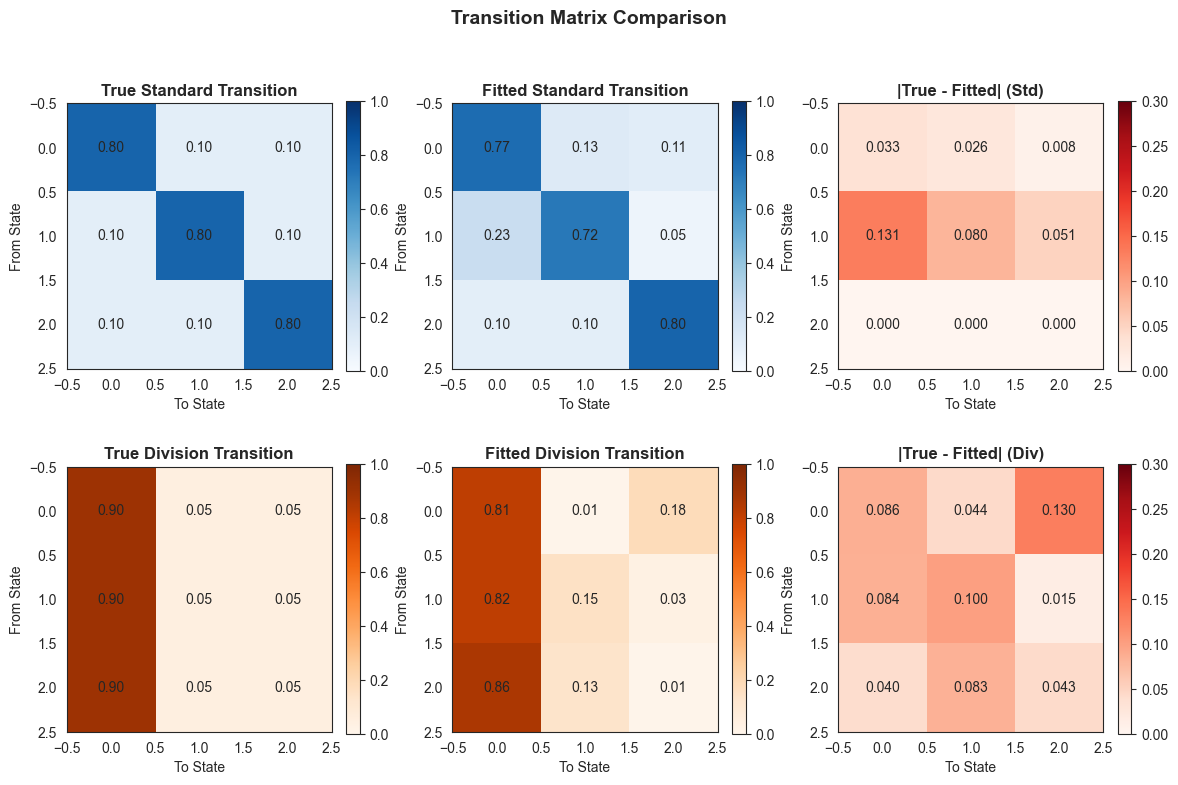

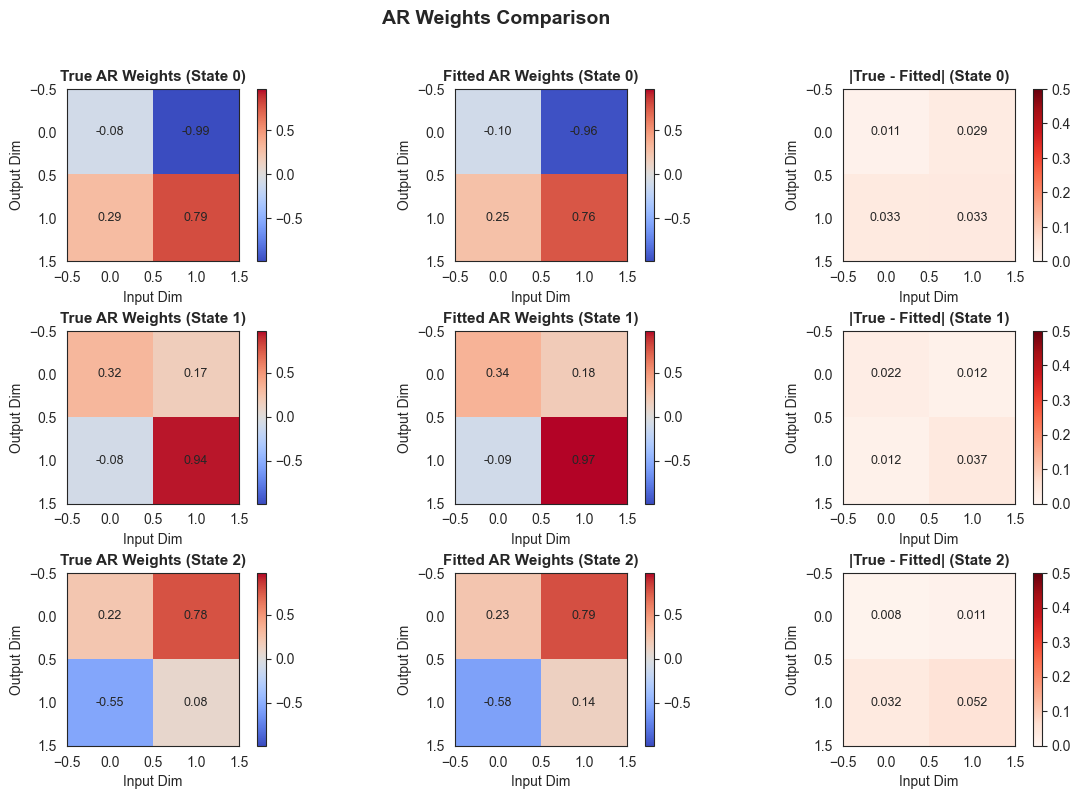

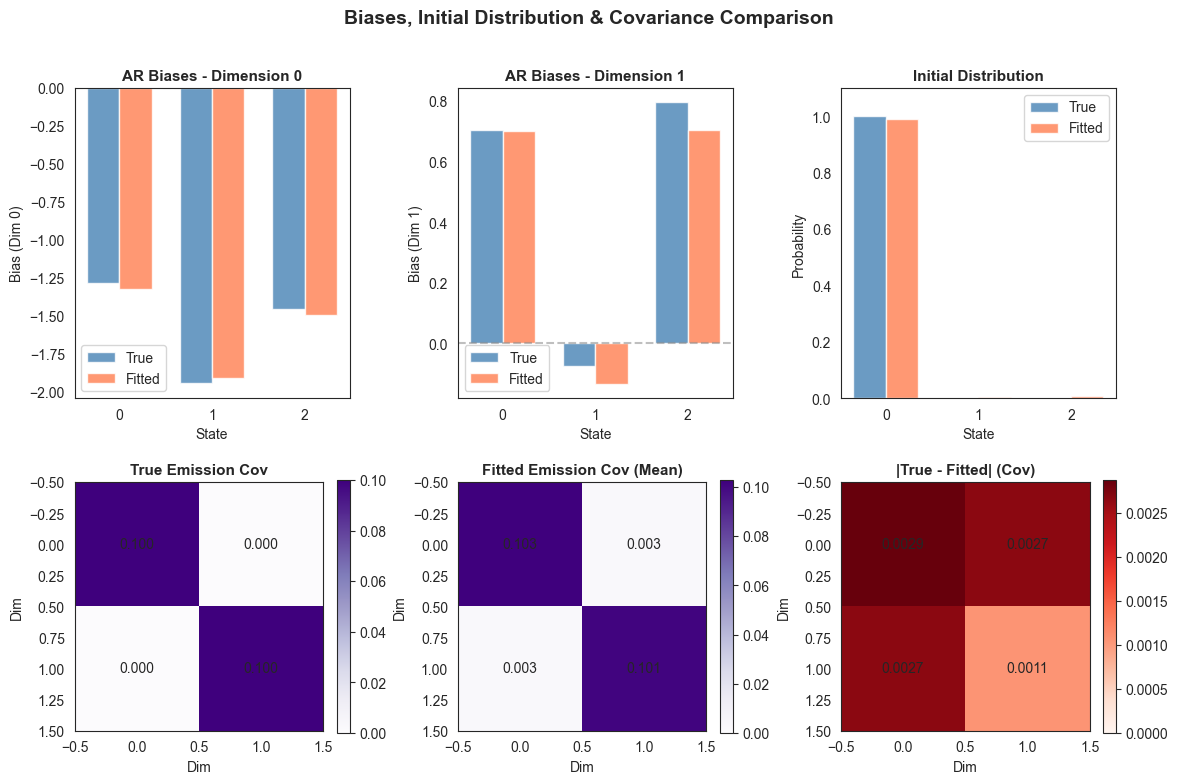


PARAMETER RECOVERY SUMMARY (after alignment)

Transition Matrix (Standard) - Mean Abs Error: 0.0366
Transition Matrix (Division) - Mean Abs Error: 0.0696
AR Weights - Mean Abs Error: 0.0244
AR Biases - Mean Abs Error: 0.0453
Emission Covariance - Mean Abs Error: 0.0023
Initial Distribution - Mean Abs Error: 0.0073


In [45]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

# Extract true and fitted parameters (raw)
true_P_std = np.array(data['transition_matrices'][0])
true_P_div = np.array(data['transition_matrices'][1])
true_weights = np.array(data['params']['AR_weights'])
true_biases = np.array(data['params']['AR_biases'])
true_cov = np.array(data['params']['cov'])
true_init = np.array(data['initial_distribution'])

fitted_P_std_raw = np.array(fitted_params.transitions.transition_matrix)
fitted_P_div_raw = np.array(fitted_params.division_transitions.transition_matrix)
fitted_weights_raw = np.array(fitted_params.emissions.weights)
fitted_biases_raw = np.array(fitted_params.emissions.biases)
fitted_cov_raw = np.array(fitted_params.emissions.covs)
fitted_init_raw = np.array(fitted_params.initial.probs)

# ============================================================================
# Find optimal state alignment using AR biases (Hungarian algorithm)
# ============================================================================
# Build cost matrix: cost[i,j] = distance between true state i and fitted state j
cost_matrix = np.zeros((num_states, num_states))
for i in range(num_states):
    for j in range(num_states):
        # Use Euclidean distance on biases
        cost_matrix[i, j] = np.linalg.norm(true_biases[i] - fitted_biases_raw[j])

# Solve assignment problem
row_ind, col_ind = linear_sum_assignment(cost_matrix)
# col_ind[i] = which fitted state corresponds to true state i
# We need the inverse: perm[j] = which true state fitted state j corresponds to
# So fitted state col_ind[i] should be relabeled as true state i

# Create permutation: perm[new_label] = old_label
# We want to reorder fitted params so fitted_aligned[i] corresponds to true[i]
perm = col_ind  # perm[true_state] = fitted_state that matches it

print("=" * 60)
print("STATE ALIGNMENT (using AR biases)")
print("=" * 60)
print(f"Cost matrix (Euclidean distance on biases):\n{cost_matrix}")
print(f"\nOptimal assignment: True state i -> Fitted state perm[i]")
print(f"Permutation: {perm}")
print(f"Total alignment cost: {cost_matrix[row_ind, col_ind].sum():.4f}")
print("=" * 60)

# Apply permutation to all fitted parameters
# For state-indexed params: reorder along state axis
fitted_biases = fitted_biases_raw[perm]
fitted_weights = fitted_weights_raw[perm]
fitted_cov = fitted_cov_raw[perm]
fitted_init = fitted_init_raw[perm]

# For transition matrices: permute both rows AND columns
# P_aligned[i,j] = P_raw[perm[i], perm[j]]
fitted_P_std = fitted_P_std_raw[perm][:, perm]
fitted_P_div = fitted_P_div_raw[perm][:, perm]

# ============================================================================
# Figure 1: Transition Matrices
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Standard Transition Matrix - True
im1 = axes[0, 0].imshow(true_P_std, cmap='Blues', vmin=0, vmax=1)
axes[0, 0].set_title('True Standard Transition', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('To State')
axes[0, 0].set_ylabel('From State')
for i in range(num_states):
    for j in range(num_states):
        axes[0, 0].text(j, i, f'{true_P_std[i, j]:.2f}', ha='center', va='center', fontsize=10)
plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)

# Standard Transition Matrix - Fitted
im2 = axes[0, 1].imshow(fitted_P_std, cmap='Blues', vmin=0, vmax=1)
axes[0, 1].set_title('Fitted Standard Transition', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('To State')
axes[0, 1].set_ylabel('From State')
for i in range(num_states):
    for j in range(num_states):
        axes[0, 1].text(j, i, f'{fitted_P_std[i, j]:.2f}', ha='center', va='center', fontsize=10)
plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)

# Standard Transition Matrix - Difference
diff_std = np.abs(true_P_std - fitted_P_std)
im3 = axes[0, 2].imshow(diff_std, cmap='Reds', vmin=0, vmax=0.3)
axes[0, 2].set_title('|True - Fitted| (Std)', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('To State')
axes[0, 2].set_ylabel('From State')
for i in range(num_states):
    for j in range(num_states):
        axes[0, 2].text(j, i, f'{diff_std[i, j]:.3f}', ha='center', va='center', fontsize=10)
plt.colorbar(im3, ax=axes[0, 2], fraction=0.046)

# Division Transition Matrix - True
im4 = axes[1, 0].imshow(true_P_div, cmap='Oranges', vmin=0, vmax=1)
axes[1, 0].set_title('True Division Transition', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('To State')
axes[1, 0].set_ylabel('From State')
for i in range(num_states):
    for j in range(num_states):
        axes[1, 0].text(j, i, f'{true_P_div[i, j]:.2f}', ha='center', va='center', fontsize=10)
plt.colorbar(im4, ax=axes[1, 0], fraction=0.046)

# Division Transition Matrix - Fitted
im5 = axes[1, 1].imshow(fitted_P_div, cmap='Oranges', vmin=0, vmax=1)
axes[1, 1].set_title('Fitted Division Transition', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('To State')
axes[1, 1].set_ylabel('From State')
for i in range(num_states):
    for j in range(num_states):
        axes[1, 1].text(j, i, f'{fitted_P_div[i, j]:.2f}', ha='center', va='center', fontsize=10)
plt.colorbar(im5, ax=axes[1, 1], fraction=0.046)

# Division Transition Matrix - Difference
diff_div = np.abs(true_P_div - fitted_P_div)
im6 = axes[1, 2].imshow(diff_div, cmap='Reds', vmin=0, vmax=0.3)
axes[1, 2].set_title('|True - Fitted| (Div)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('To State')
axes[1, 2].set_ylabel('From State')
for i in range(num_states):
    for j in range(num_states):
        axes[1, 2].text(j, i, f'{diff_div[i, j]:.3f}', ha='center', va='center', fontsize=10)
plt.colorbar(im6, ax=axes[1, 2], fraction=0.046)

plt.suptitle('Transition Matrix Comparison', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout(pad=1.5, w_pad=0.5, h_pad=0.5)
plt.show()

# ============================================================================
# Figure 2: AR Weights (per state)
# ============================================================================
fig, axes = plt.subplots(num_states, 3, figsize=(12, 8))

vmin_w = min(true_weights.min(), fitted_weights.min())
vmax_w = max(true_weights.max(), fitted_weights.max())

for k in range(num_states):
    # True Weights
    im1 = axes[k, 0].imshow(true_weights[k], cmap='coolwarm', vmin=vmin_w, vmax=vmax_w)
    axes[k, 0].set_title(f'True AR Weights (State {k})', fontsize=11, fontweight='bold')
    axes[k, 0].set_xlabel('Input Dim')
    axes[k, 0].set_ylabel('Output Dim')
    for i in range(emission_dim):
        for j in range(emission_dim):
            axes[k, 0].text(j, i, f'{true_weights[k, i, j]:.2f}', ha='center', va='center', fontsize=9)
    plt.colorbar(im1, ax=axes[k, 0], fraction=0.046)
    
    # Fitted Weights
    im2 = axes[k, 1].imshow(fitted_weights[k], cmap='coolwarm', vmin=vmin_w, vmax=vmax_w)
    axes[k, 1].set_title(f'Fitted AR Weights (State {k})', fontsize=11, fontweight='bold')
    axes[k, 1].set_xlabel('Input Dim')
    axes[k, 1].set_ylabel('Output Dim')
    for i in range(emission_dim):
        for j in range(emission_dim):
            axes[k, 1].text(j, i, f'{fitted_weights[k, i, j]:.2f}', ha='center', va='center', fontsize=9)
    plt.colorbar(im2, ax=axes[k, 1], fraction=0.046)
    
    # Difference
    diff_w = np.abs(true_weights[k] - fitted_weights[k])
    im3 = axes[k, 2].imshow(diff_w, cmap='Reds', vmin=0, vmax=0.5)
    axes[k, 2].set_title(f'|True - Fitted| (State {k})', fontsize=11, fontweight='bold')
    axes[k, 2].set_xlabel('Input Dim')
    axes[k, 2].set_ylabel('Output Dim')
    for i in range(emission_dim):
        for j in range(emission_dim):
            axes[k, 2].text(j, i, f'{diff_w[i, j]:.3f}', ha='center', va='center', fontsize=9)
    plt.colorbar(im3, ax=axes[k, 2], fraction=0.046)

plt.suptitle('AR Weights Comparison', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout(pad=1.5, w_pad=0.5, h_pad=0.5)
plt.show()

# ============================================================================
# Figure 3: Biases, Initial Distribution, and Covariances
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Biases Comparison (Bar Chart)
x = np.arange(num_states)
width = 0.35
for d in range(emission_dim):
    axes[0, d].bar(x - width/2, true_biases[:, d], width, label='True', color='steelblue', alpha=0.8)
    axes[0, d].bar(x + width/2, fitted_biases[:, d], width, label='Fitted', color='coral', alpha=0.8)
    axes[0, d].set_xlabel('State')
    axes[0, d].set_ylabel(f'Bias (Dim {d})')
    axes[0, d].set_title(f'AR Biases - Dimension {d}', fontsize=11, fontweight='bold')
    axes[0, d].set_xticks(x)
    axes[0, d].legend()
    axes[0, d].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Initial Distribution Comparison
axes[0, 2].bar(x - width/2, true_init, width, label='True', color='steelblue', alpha=0.8)
axes[0, 2].bar(x + width/2, fitted_init, width, label='Fitted', color='coral', alpha=0.8)
axes[0, 2].set_xlabel('State')
axes[0, 2].set_ylabel('Probability')
axes[0, 2].set_title('Initial Distribution', fontsize=11, fontweight='bold')
axes[0, 2].set_xticks(x)
axes[0, 2].legend()
axes[0, 2].set_ylim([0, 1.1])

# Covariance matrices (only showing first state as they should all be the same for true)
# True covariance (same for all states in data generation)
im_cov1 = axes[1, 0].imshow(true_cov, cmap='Purples', vmin=0)
axes[1, 0].set_title('True Emission Cov', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Dim')
axes[1, 0].set_ylabel('Dim')
for i in range(emission_dim):
    for j in range(emission_dim):
        axes[1, 0].text(j, i, f'{true_cov[i, j]:.3f}', ha='center', va='center', fontsize=10)
plt.colorbar(im_cov1, ax=axes[1, 0], fraction=0.046)

# Fitted covariances (average across states or show state 0)
fitted_cov_mean = np.mean(fitted_cov, axis=0)
im_cov2 = axes[1, 1].imshow(fitted_cov_mean, cmap='Purples', vmin=0)
axes[1, 1].set_title('Fitted Emission Cov (Mean)', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Dim')
axes[1, 1].set_ylabel('Dim')
for i in range(emission_dim):
    for j in range(emission_dim):
        axes[1, 1].text(j, i, f'{fitted_cov_mean[i, j]:.3f}', ha='center', va='center', fontsize=10)
plt.colorbar(im_cov2, ax=axes[1, 1], fraction=0.046)

# Covariance Difference
diff_cov = np.abs(true_cov - fitted_cov_mean)
im_cov3 = axes[1, 2].imshow(diff_cov, cmap='Reds', vmin=0)
axes[1, 2].set_title('|True - Fitted| (Cov)', fontsize=11, fontweight='bold')
axes[1, 2].set_xlabel('Dim')
axes[1, 2].set_ylabel('Dim')
for i in range(emission_dim):
    for j in range(emission_dim):
        axes[1, 2].text(j, i, f'{diff_cov[i, j]:.4f}', ha='center', va='center', fontsize=10)
plt.colorbar(im_cov3, ax=axes[1, 2], fraction=0.046)

plt.suptitle('Biases, Initial Distribution & Covariance Comparison', fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout(pad=1.5, w_pad=0.5, h_pad=0.5)
plt.show()

# ============================================================================
# Summary Statistics
# ============================================================================
print("\n" + "=" * 60)
print("PARAMETER RECOVERY SUMMARY (after alignment)")
print("=" * 60)
print(f"\nTransition Matrix (Standard) - Mean Abs Error: {np.mean(diff_std):.4f}")
print(f"Transition Matrix (Division) - Mean Abs Error: {np.mean(diff_div):.4f}")
print(f"AR Weights - Mean Abs Error: {np.mean(np.abs(true_weights - fitted_weights)):.4f}")
print(f"AR Biases - Mean Abs Error: {np.mean(np.abs(true_biases - fitted_biases)):.4f}")
print(f"Emission Covariance - Mean Abs Error: {np.mean(diff_cov):.4f}")
print(f"Initial Distribution - Mean Abs Error: {np.mean(np.abs(true_init - fitted_init)):.4f}")


## Todo: make a new plot here with MAP state assignment for some cell and plot versus ground truth

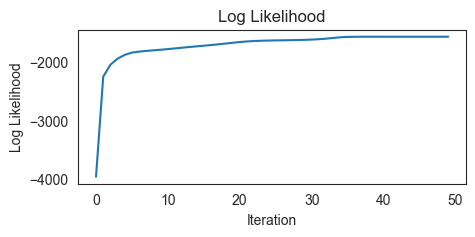

In [46]:
plt.figure(figsize=[5,2])
plt.plot(lps)
plt.title('Log Likelihood')
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.show()




In [47]:
input_fwd = arhmm._inference_args(params, emissions, inputs, data['parent_indices'], data['is_division_mask'], data['active_mask'],data['is_new_root_mask'])

posterior = tree_hmm_two_filter_smoother(*input_fwd)

(4.0, 15.0)

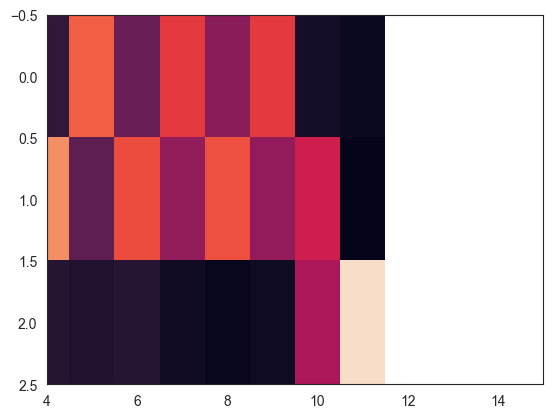

In [48]:
plt.imshow(posterior.smoothed_probs[:,1,:].T, aspect="auto", interpolation="none", vmin=0, vmax=1)
plt.xlim(4,15)

In [49]:
posterior

TreeHMMPosterior(marginal_loglik=Array(-1977.7637, dtype=float32), filtered_probs=Array([[[0.8067522 , 0.00195304, 0.19129474],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.09321962, 0.5740108 , 0.33276957],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.36884335, 0.3956037 , 0.23555289],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        ,

In [ ]:
posterior.smoothed_probs.shape

(100, 256, 3)